In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Probit vs Sigmoid

$$ \sigma(t) = \frac{1}{1+\exp(-t)} $$
$$ \Phi(\lambda t) = \int_{-\infty}^{\lambda t} N(\theta|0,1) d\theta, \quad \lambda=\frac{\sqrt{\pi}}{8} $$

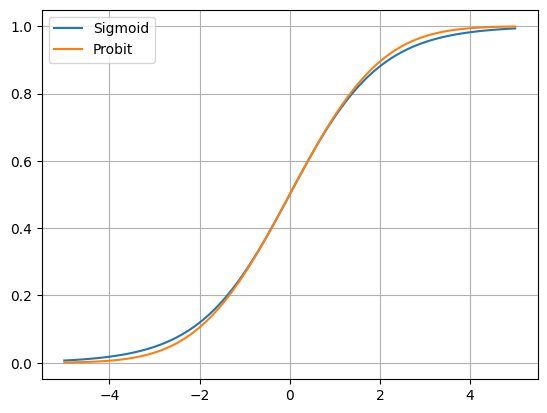

In [3]:
x = np.linspace(-5,5,101)
y_sigmoid = 1/(1+np.exp(-x))
y_probit = norm.cdf(x * np.sqrt(np.pi/8))

plt.plot(x, y_sigmoid, label='Sigmoid')
plt.plot(x, y_probit, label='Probit')
plt.grid()
plt.legend()

# Dataset

$$\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N, \quad x_i \in \mathbb{R}^2, y_i\in\{0,1\}, i=1,\ldots,N$$

(200, 3) (200,)


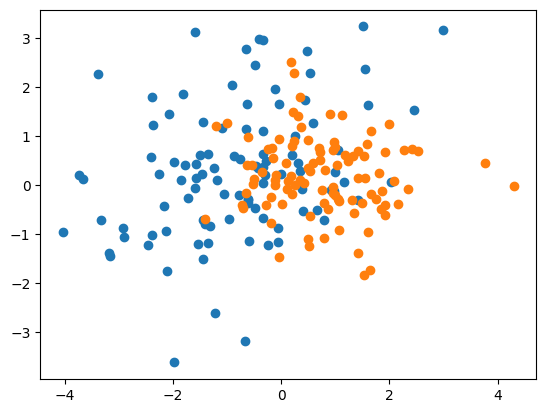

In [4]:
N=100
m1 = np.array([-1., 0.])
Cov1 = np.array([[2., 0.5], [0.5, 2.]])
L1 = np.linalg.cholesky(Cov1)

m2 = np.array([1., 0.])
Cov2 = np.array([[1., 0.0], [0.0, 0.5]])
L2 = np.linalg.cholesky(Cov2)
data1 = m1 + np.random.randn(N,2) @ L1.T
data2 = m2 + np.random.randn(N,2) @ L2.T

X = np.hstack([np.vstack([data1, data2]), np.ones((2*N, 1))])
y= np.concatenate([np.ones(N), np.zeros(N)])
print(X.shape, y.shape)

plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])

# Prior

$$\mathbf{w} \sim N(m_0, S_0), \quad \mathbf{w}=[w_1, w_2, b] \in \mathbb{R}^3$$

In [5]:
Np = 100
m0 = np.array([0., 0., 0.])
S0 = np.array([[3., 0., 0.], [0., 3., 0.], [0., 0., 3.]])
L0 = np.linalg.cholesky(S0)
w0s = m0 + np.random.randn(Np, 3) @ L0.T

(-3.622776681271679, 3.233207447657386)

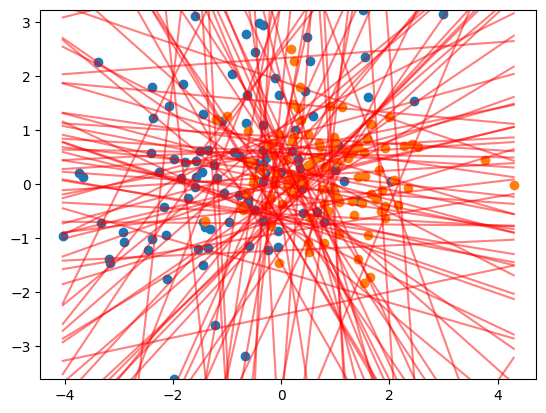

In [6]:
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
xspan = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 101)
for i in range(Np):
    w = w0s[i]
    plt.plot(xspan, xspan*(-w[0]/w[1]) - w[2]/w[1], 'r', alpha=0.5)
plt.ylim([np.min(X[:,1]), np.max(X[:,1])])

# MAP

Likelihood:
\begin{align}
P(y_i|\mathbf{x}_i, \mathbf{w}) & = P(y_i=1|\mathbf{x}_i, \mathbf{w})^{y_i} \cdot (1-P(y_i=1|\mathbf{x}_i, \mathbf{w}))^{1-y_i}\\
& = \hat{y}_i^{y_i} \cdot (1-\hat{y}_i)^{1-y_i}
\end{align}
$$\hat{y}_i \equiv P(y_i=1|\mathbf{x}_i, \mathbf{w}) = \frac{1}{1+\exp(\mathbf{w}^\top \mathbf{x})}, \quad \mathbf{x}_i = [x_i^{(1)}, x_i^{(2)}, 1] \in \mathbb{R}^3$$

Posterior:
$$p(\mathbf{w}|\mathbf{y}, X) \propto \prod_{i=1}^N P(y_i|\mathbf{x}_i, \mathbf{w}) \cdot p(\mathbf{w})$$

Log posterior:
\begin{align}
\log p(\mathbf{w}|\mathbf{y}, X) & = \log p(\mathbf{w}) + \sum_{i=1}^N \log P(y_i|\mathbf{x}_i, \mathbf{w}) \\
& = -\frac{1}{2} (\mathbf{w} - m_0)^\top S_0^{-1} (\mathbf{w} - m_0) - \sum_{i=1}^N \left( y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i) \right) + const.
\end{align}

Gradient of log posterior:
\begin{align}
\frac{\partial \log p(\mathbf{w}|\mathbf{y}, X)}{\partial \mathbf{w}} & = -S_0^{-1}(\mathbf{w} - m_0) + \sum_{i=1}^N (y_i - \hat{y}_i) \mathbf{x}_i \\
& = -S_0^{-1}(\mathbf{w} - m_0) + X^\top (\mathbf{y} - \hat{\mathbf{y}}),
\end{align}
$$X = [\mathbf{x}_1, \ldots, \mathbf{x}_N]^\top \in \mathbb{R}^{N\times D}, \ \mathbf{y} = [y_1, \ldots, y_N] \in \mathbb{R}^{N}, \ \hat{\mathbf{y}} = [\hat{y}_1, \ldots, \hat{y}_N] \in \mathbb{R}^{N}$$

Gradient ascent for maximum a posteriori (MAP):

For $t=0, \ldots, T$,
$$ \mathbf{w}_{t+1} = \mathbf{w}_t + \eta * \frac{\partial \log p(\mathbf{w}|\mathbf{y}, X)}{\partial \mathbf{w}},$$
where $\eta > 0$ is a step size.

In [7]:
def pred(w, X):
    return 1/(1+np.exp(-X @ w.reshape(-1,1))).reshape(-1)

def log_posterior(w, m0, S0, X, y):
    S0_inv = np.linalg.inv(S0)
    yhat = pred(w, X)
    diff = (w - m0)
    return -0.5*diff @ S0_inv @ diff + np.sum(y * np.log(yhat) + (1-y) * np.log(1-yhat))

def gradient_MAP(w, m0, S0, X, y):
    S0_inv = np.linalg.inv(S0)
    yhat = pred(w, X)
    return -S0_inv @ (w - m0) + X.T @ (y - yhat)

In [8]:
w_init = np.random.randn(3)
N_iter = 100
step_size = 0.01
w_traj = []
w_traj.append(np.array(w_init))
log_pos_traj = []
log_pos_traj.append(log_posterior(w_init, m0, S0, X, y))
for t in range(N_iter):
    w = w_traj[-1]
    w_traj.append(w + step_size * gradient_MAP(w, m0, S0, X, y))
    log_pos_traj.append(log_posterior(w_traj[-1], m0, S0, X, y))

Text(0, 0.5, 'Log posterior')

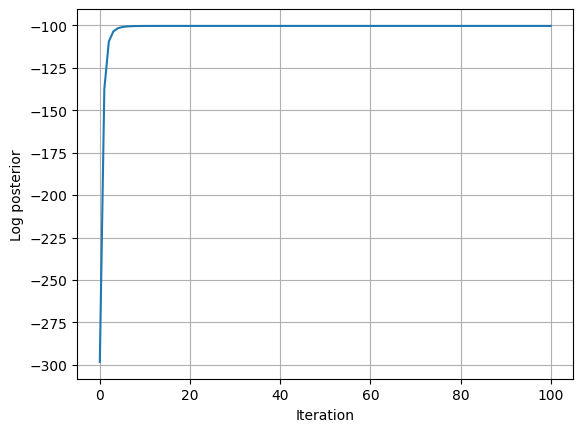

In [9]:
plt.plot(log_pos_traj)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Log posterior')

(-3.622776681271679, 3.233207447657386)

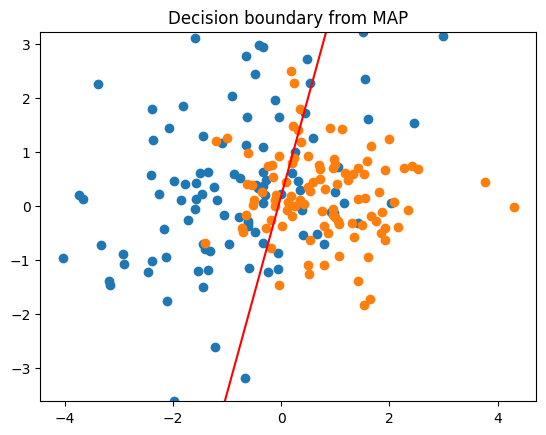

In [21]:
w_MAP = w_traj[-1]
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.plot(xspan, xspan*(-w_MAP[0]/w_MAP[1]) - w_MAP[2]/w_MAP[1], 'r')
plt.title('Decision boundary from MAP')
plt.ylim([np.min(X[:,1]), np.max(X[:,1])])

# Laplace approximation

$$q(w) = N(\mathbf{w}_{MAP}, S_N)$$
$$S_N^{-1} = -\frac{\partial^2 \log p(\mathbf{w}|\mathbf{y}, X)}{\partial \mathbf{w}^2} = S_0^{-1} + \sum_{i=1}^N \hat{y}_i (1 - \hat{y}_i) \mathbf{x}_i \mathbf{x}_i^\top$$

In [10]:
def S_N(w_MAP, S0, X):
    S0_inv = np.linalg.inv(S0)
    yhat = pred(w_MAP, X)
    SN_inv = S0_inv + np.sum((yhat * (1-yhat)).reshape(-1,1,1) * (X[:,:,np.newaxis] * X[:,np.newaxis,:]), axis=0)
    return np.linalg.inv(SN_inv)

In [11]:
w_MAP = w_traj[-1]
SN = S_N(w_MAP, S0, X)

# Prediction

\begin{align}
P(y=1|\mathbf{x}, \mathbf{y}, X) & = \int P(y=1|\mathbf{x}, \mathbf{w}) p(\mathbf{w}|\mathbf{y}, X) d\mathbf{w} \\
& \approx \int \Phi(\lambda \mathbf{w}^\top \mathbf{x}) q(\mathbf{w}) d\mathbf{w} \\
& = \int_{-\infty}^{\infty} \Phi(\lambda a) q_\mathbf{x}(a) da \\
& = \Phi\left(\frac{\mu(\mathbf{\mathbf{x}})}{\sqrt{\sigma^2(\mathbf{\mathbf{x}}) + \lambda^{-2}}}\right),
\end{align}
where $q_\mathbf{x}(a) = \int \delta(a-\mathbf{w}^\top \mathbf{x}) q(\mathbf{w}) d\mathbf{w} = N(a|\mu(\mathbf{x}), \sigma^2(\mathbf{x})), \quad \mu(\mathbf{x}) = \mathbf{w}_{MAP}^\top \mathbf{x}, \quad \sigma^2(\mathbf{\mathbf{x}}) = \mathbf{x}^\top S_N \mathbf{x}.$

Prediction using sigmoid function:
$$P(y=1|\mathbf{x}, \mathbf{y}, X) \approx \sigma\left( \frac{\mu(\mathbf{\mathbf{x}})}{\sqrt{1 + \lambda^{2}\sigma^2(\mathbf{\mathbf{x}})}} \right)$$

In [12]:
def pred_from_probit(x, w_MAP, SN):
    mu = x @ w_MAP
    sigma_sq = (x @ SN * x).sum(axis=1)
    lambda_ = np.sqrt(np.pi/8)
    return norm.cdf(mu/np.sqrt(sigma_sq + lambda_**-2))

def pred_from_sigmoid(x, w_MAP, SN):
    mu = x @ w_MAP
    sigma_sq = (x @ SN * x).sum(axis=1)
    kappa = (1 + np.pi/8 * sigma_sq)**(-0.5)
    return 1/(1+np.exp(-kappa*mu))

In [13]:
x1s = np.linspace(-5,5,101)
x2s = np.linspace(-5,5,201)

X1s, X2s = np.meshgrid(x1s, x2s)

print(X1s.shape, X2s.shape)

X1s = X1s.reshape(-1,1)
X2s = X2s.reshape(-1,1)

yhat_probit = pred_from_probit(np.hstack([X1s, X2s, np.ones((len(X1s),1))]), w_MAP, SN).reshape(len(x2s), len(x1s))
yhat_sigmoid = pred_from_sigmoid(np.hstack([X1s, X2s, np.ones((len(X1s),1))]), w_MAP, SN).reshape(len(x2s), len(x1s))

(201, 101) (201, 101)


Text(0.5, 1.0, 'Prediction from probit function')

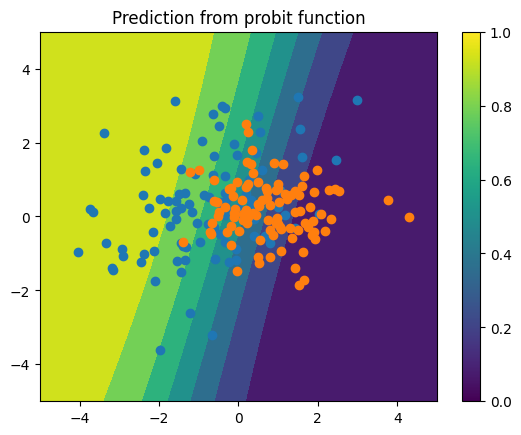

In [14]:
plt.contourf(x1s, x2s, yhat_probit)
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.colorbar()
plt.title('Prediction from probit function')

Text(0.5, 1.0, 'Prediction from sigmoid function')

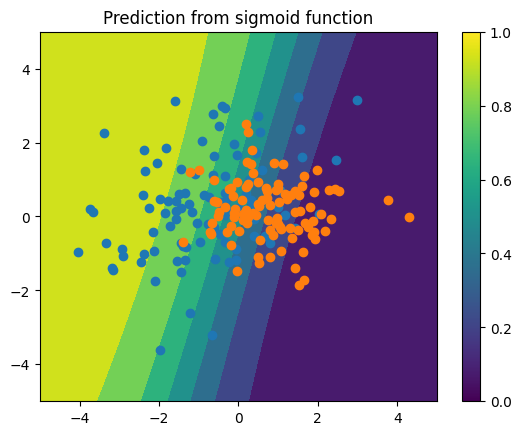

In [15]:
plt.contourf(x1s, x2s, yhat_sigmoid)
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.colorbar()
plt.title('Prediction from sigmoid function')

# Variance of prediction ($\hat{y}(x)$)

\begin{align}
Var(\hat{y}|\mathbf{x}, \mathbf{y}, X) & = \mathbb{E}_\mathbf{w}[P(y=1|\mathbf{x}, \mathbf{w})^2]- \mathbb{E}_\mathbf{w}[P(y=1|\mathbf{x}, \mathbf{w})]^2
\end{align}
\begin{align}
\mathbb{E}_\mathbf{w}[P(y=1|\mathbf{x}, \mathbf{w})^2] 
& = \int P(y=1|\mathbf{x}, \mathbf{w})^2 p(\mathbf{w}|\mathbf{y}, X) d\mathbf{w} \\
 & \approx \int \Phi(\lambda \mathbf{w}^\top \mathbf{x})^2 q(\mathbf{w}) d\mathbf{w} \\
& = \int_{-\infty}^{\infty} \Phi(\lambda a)^2 q_\mathbf{x}(a) da \\
& = \Phi_2 \left(
\frac{\lambda \mu(\mathbf{\mathbf{x}})}{\sqrt{1 + \lambda^{2}\sigma^{2}(\mathbf{\mathbf{x}})}}, 
\frac{\lambda \mu(\mathbf{\mathbf{x}})}{\sqrt{1 + \lambda^{2}\sigma^{2}(\mathbf{\mathbf{x}})}}, 
\frac{\lambda^2 \sigma^{2}(\mathbf{\mathbf{x}})}{1 + \lambda^{2}\sigma^{2}(\mathbf{\mathbf{x}})}
\right),
\end{align}
where $\Phi_2(t_1; t_2; \rho)=P(x_1 \leq t_1, x_2 \leq t_2)$ is the CDF of bivariate standard normal with correlation $\rho$.

In [16]:
def probit_square_integral(lam, mu, sigma):
    """Closed-form ∫ Φ(λa)^2 𝓝(a|μ,σ²) da."""
    kappa = lam * mu / np.sqrt(1 + (lam**2) * (sigma**2))
    rho   = (lam**2) * (sigma**2) / (1 + (lam**2) * (sigma**2))
    cov   = [[1, rho], [rho, 1]]
    return multivariate_normal.cdf([kappa, kappa], mean=[0, 0], cov=cov)

def yhat_sq_expectation(x, w_MAP, SN):
    mu = x @ w_MAP
    sigma = np.sqrt((x @ SN * x).sum(axis=1))
    lambda_ = np.sqrt(np.pi/8)
    return np.array([probit_square_integral(lambda_, mu_, sigma_) for mu_, sigma_ in zip(mu, sigma)])

In [17]:
var_yhat = yhat_sq_expectation(np.hstack([X1s, X2s, np.ones((len(X1s),1))]), w_MAP, SN) \
- pred_from_probit(np.hstack([X1s, X2s, np.ones((len(X1s),1))]), w_MAP, SN)**2

Text(0.5, 1.0, 'Prediction variance from probit approximation')

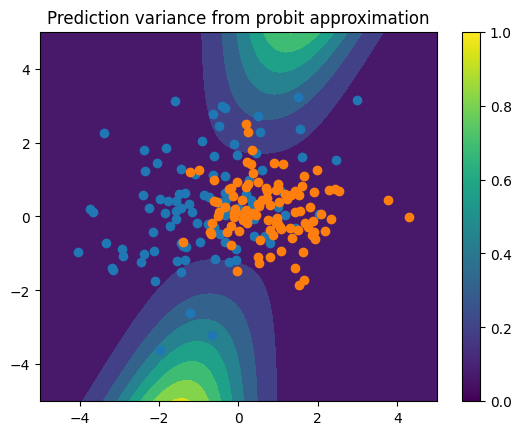

In [19]:
plt.contourf(x1s, x2s, var_yhat.reshape(len(x2s), len(x1s)))
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.colorbar()
plt.title('Prediction variance from probit approximation')